In [1]:
#import dependencies
import pandas as pd
import numpy as np
import requests
import json
import random
import matplotlib.pyplot as plt


# Clean Census Data and filter for counties to query yelp data for

In [2]:
#path to CSV file
csv_path="2015_census_tract_data.csv"

#read CSV file
Census_file=pd.read_csv(csv_path)


In [3]:
#check to see if there are rows with missing data
#Census_file.count()

In [4]:
#remove rows with missing data
clean_census_file=Census_file.dropna(how="any")
#clean_census_file.count()

In [5]:
#column names
#clean_census_file.columns

In [6]:
#create a dataframe from the file
DF_census_file=pd.DataFrame(clean_census_file)
#DF_census_file.head()

In [7]:
grouped_income = DF_census_file.groupby(["State","County"]).apply(lambda x: np.average(x["Income"],weights=x["TotalPop"]))
grouped_income=pd.DataFrame(grouped_income,columns=["Income"])
grouped_income=grouped_income.reset_index()
grouped_income["ID"] = grouped_income["State"]+grouped_income["County"]
#grouped_income.head()

In [8]:
#find total number of people per ethnicity
DF_census_file["Hispanic Population"]=(DF_census_file["Hispanic"]/100)*DF_census_file["TotalPop"]
DF_census_file["White Population"]=(DF_census_file["White"]/100)*DF_census_file["TotalPop"]
DF_census_file["Black Population"]=(DF_census_file["Black"]/100)*DF_census_file["TotalPop"]
DF_census_file["Native Population"]=(DF_census_file["Native"]/100)*DF_census_file["TotalPop"]
DF_census_file["Asian Population"]=(DF_census_file["Asian"]/100)*DF_census_file["TotalPop"]
DF_census_file["Pacific Population"]=(DF_census_file["Pacific"]/100)*DF_census_file["TotalPop"]
DF_census_file["Other Population"]=DF_census_file["TotalPop"]-DF_census_file["Pacific Population"]-DF_census_file["Asian Population"]-DF_census_file["Native Population"]-DF_census_file["Hispanic Population"]-DF_census_file["White Population"]-DF_census_file["Black Population"]
DF_census_file["ID"]=DF_census_file["State"]+DF_census_file["County"]


In [9]:
TractCount=DF_census_file.groupby(["State","County"]).count()["CensusTract"]
TractCount=pd.DataFrame(TractCount)
TractCount=TractCount.reset_index()
#TractCount.head()

In [10]:
#F_census_file.head()

In [11]:
Test_census_file=DF_census_file[["State","County","ID","TotalPop","Men","Women","Hispanic Population","White Population","Black Population","Native Population","Asian Population","Other Population"]]
Test_census_file=Test_census_file.groupby(["State","County","ID"],as_index=False).sum()
#Test_census_file.head()

In [12]:
merge_table=pd.merge(Test_census_file,grouped_income,on=["State","County","ID"] ,how="outer")
#merge_table.head()


In [13]:
merge_table=pd.merge(merge_table,TractCount,on=["State","County"],how="outer")
#merge_table.head()

In [14]:
#Filter
merge_table["Hispanic Population %"]=merge_table["Hispanic Population"]/merge_table["TotalPop"]*100
merge_table["White Population %"]=merge_table["White Population"]/merge_table["TotalPop"]*100
merge_table["Black  Population %"]=merge_table["Black Population"]/merge_table["TotalPop"]*100
merge_table["Asian Population %"]=merge_table["Asian Population"]/merge_table["TotalPop"]*100
merge_table["Other Population %"]=merge_table["Other Population"]/merge_table["TotalPop"]*100
merge_table["Native Population %"]=merge_table["Native Population"]/merge_table["TotalPop"]*100
merge_table["% Men"]=merge_table["Men"]/merge_table["TotalPop"]*100
merge_table["% Women"]=merge_table["Women"]/merge_table["TotalPop"]*100


In [15]:
#merge_table.head()

In [16]:
merged_clean=merge_table[["State","County","TotalPop","Income","CensusTract","White Population %","Hispanic Population %",
                         "Black  Population %","Asian Population %", "Native Population %","Other Population %", "% Men", "% Women"]]

In [17]:
#merged_clean.head()


In [18]:
#create datasets
#exclude puerto rico
America_County=merged_clean[(merged_clean["State"]!="Puerto Rico")&(merged_clean["TotalPop"]>100000)]

#Poor County are counties with incomes less than $25,000
Poor_County=America_County.query("Income<40000")

#Rich County are counties with income more than $75,000
Rich_County=America_County[(America_County["Income"]>75000)& (America_County["CensusTract"]<75)]

#Asian County are counties with Asians making up more than 20% of the population
Asian_County=America_County[(America_County["Asian Population %"]>20)] 

#Black County are counties with Asians making up more than 20% of the population
Latino_County=America_County[(America_County["Hispanic Population %"]>50)] 

#NonDiverse County are counties where one ethnic group makes up more than 80% of the population with a population greater than 400,000
NonDiverse_County=America_County[(America_County["TotalPop"]>400000)&((America_County["White Population %"]>80))]

LA_County=America_County.loc[America_County["County"]=="Los Angeles",:]

In [19]:
#Latino_County

In [20]:
#creating CSV Files
#Diverse_County.to_csv("Diverse_County.csv")
NonDiverse_County.to_csv("NonDiverse_County.csv")
Poor_County.to_csv("Poor_County.csv")
Rich_County.to_csv("Rich_County.csv")

In [21]:
la_county_yelp=America_County.loc[America_County["County"]=="Los Angeles",:]

# Yelp Set Up and Data Retreival

In [22]:

import requests
import pprint
import json
from urllib.parse import quote

api_key="HTxE_2fiZiukf88_6zgw-998n3g0Hp2VCZVttuzh8PYAVGYnMqjyF-20vFikX40klyhOv4-s98YvoQNi0WoNSqRkLhKzc6Go8PCNpheK3map5VsYo69Sl5haqpaoWnYx"

API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.

Default_Term="restaurant"
Limit_Count=50



In [23]:
#define function to pull information from yelp
def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)
    return response.json()


In [24]:
#function to pull restaurants based by location
def search(api_key,term,location):
#term: the search term (restaurant)
#location: The search location passed to the api
#returns: the json response
    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': Limit_Count,
        'sort_by': 'rating'
      }
    return request(API_HOST,SEARCH_PATH,api_key,url_params=url_params)



In [25]:
#Create a function to loop through county datasets


def YelpDF_byCountyType(data_set):

    #create lists to store yelp information
    Restaurant_Name=[]
    Restaurant_City=[]
    Restaurant_State=[]
    Restaurant_zip=[]
    Restaurant_price_cat=[]
    Restaurant_rating=[]
    Restaurant_type=[]
    Restaurant_County=[]
    Restaurant_ReviewCount=[]

    for index,row in data_set.iterrows():
        #print(f"{row['County']}, {row['State']}")
        datatest=search(api_key,"Restaurant",f"{row['County']}, {row['State']}")
        #print(datatest)
        for i in range(Limit_Count):
            #Append Restaurant Name
            try:
                Restaurant_Name.append(datatest["businesses"][i]["name"])
            except IndexError:
                continue
                
            except len(datatest["businesses"][i]["name"])==0:
                Restaurant_Name.append(0)
                

            #Append Restaurant Zip code
            try:  
                Restaurant_zip.append(datatest["businesses"][i]["location"]["zip_code"])
            except len(Restaurant_zip.append(datatest["businesses"][i]["location"]["zip_code"]))==0:
                Restaurant_zip.append('')  

            #appent Restaurant City code
            try:
                Restaurant_City.append(datatest["businesses"][i]["location"]["city"])
            except len(Restaurant_City.append(datatest["businesses"][i]["location"]["city"]))==0:
                Restaurant_City.append('')

            #append county
            try:
                Restaurant_County.append(row['County'])
            except:
                Restaurant_County.append(row['County'])

            #Append State
            try:
                Restaurant_State.append(row)
            except len(Restaurant_State.append(datatest["businesses"][i]["location"]["state"]))==0:
                Restaurant_State.append(row['State'])

            #Append Restaurant Rating
            try:
                Restaurant_rating.append(datatest["businesses"][i]["rating"])  
            except len(Restaurant_rating.append(datatest["businesses"][i]["rating"]))==0:
                Restaurant_rating.append('')

            #Append Restaurant Type
            try: 
                Restaurant_type.append(datatest["businesses"][i]["categories"][0]["title"])
            except:
                Restaurant_type.append('')

            #Append Restaurant Review Count
            try:
                Restaurant_ReviewCount.append(datatest["businesses"][i]["review_count"])
            except:
                Restaurant_ReviewCount.append(0)

            #append Restaurant Price

            try:
                Restaurant_price_cat.append(datatest["businesses"][i]["price"])
            except KeyError:
                Restaurant_price_cat.append('')
            except len(Restaurant_price_cat.append(datatest["businesses"][i]["price"]))== 0:
                Restaurant_price_cat.append('')

            Yelp_df=pd.DataFrame({"Restaurant Name":Restaurant_Name,"Restaurant City":Restaurant_City,"State":Restaurant_State,
                     "ZipCode":Restaurant_zip,"Type":Restaurant_type,
                      "Rating":Restaurant_rating,"County":Restaurant_County,"Review Count":Restaurant_ReviewCount, 
                     "Price Cat":Restaurant_price_cat})
            merged_df=pd.merge(Yelp_df,data_set,on=["County"] ,how="outer")
    return merged_df        
    
  
    
    
    
    
    



In [26]:
#pull yelp data for different county datasets
Poor_County_Yelp_df=YelpDF_byCountyType(Poor_County)


Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...


In [27]:
Poor_County_Yelp_df.head()
Poor_County_Yelp_df["County"].count()

450

In [28]:
Rich_County_Yelp_df=YelpDF_byCountyType(Rich_County)


Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying h

In [29]:
Rich_County_Yelp_df.head()
Rich_County_Yelp_df["County"].count()

1797

In [30]:
Asian_County_Yelp_df=YelpDF_byCountyType(Asian_County)

Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...


In [31]:
Latino_County_Yelp_df=YelpDF_byCountyType(Latino_County)

Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying h

In [32]:
NonDiverse_County_Yelp_df=YelpDF_byCountyType(NonDiverse_County)

Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/search ...


In [33]:
NonDiverse_County_Yelp_df.head(20)

,County,Price Cat,Rating,Restaurant City,Restaurant Name,Review Count,State_x,Type,ZipCode,State_y,...,Income,CensusTract,White Population %,Hispanic Population %,Black Population %,Asian Population %,Native Population %,Other Population %,% Men,% Women
0,Ada,$$$,5.0,Meridian,Epi's A Basque Restaurant,193,State Idaho County ...,Basque,83642,Idaho,...,60972.339355,59,85.555919,7.61408,1.095972,2.566507,0.462834,2.547257,50.030778,49.969222
1,Ada,$$,5.0,Boise,Cucina Di Paolo,142,State Idaho County ...,Italian,83705,Idaho,...,60972.339355,59,85.555919,7.61408,1.095972,2.566507,0.462834,2.547257,50.030778,49.969222
2,Ada,$,4.5,Boise,Tango's Subs and Empanadas,297,State Idaho County ...,Argentine,83706,Idaho,...,60972.339355,59,85.555919,7.61408,1.095972,2.566507,0.462834,2.547257,50.030778,49.969222
3,Ada,$$,4.5,Nampa,JP Thailand Express,159,State Idaho County ...,Thai,83686,Idaho,...,60972.339355,59,85.555919,7.61408,1.095972,2.566507,0.462834,2.547257,50.030778,49.969222
4,Ada,$$,4.5,Boise,Kibrom's Restaurant,98,State Idaho County ...,Ethiopian,83703,Idaho,...,60972.339355,59,85.555919,7.61408,1.095972,2.566507,0.462834,2.547257,50.030778,49.969222
5,Ada,$$,4.5,Boise,Wild Root Café & Market,127,State Idaho County ...,Breakfast & Brunch,83702,Idaho,...,60972.339355,59,85.555919,7.61408,1.095972,2.566507,0.462834,2.547257,50.030778,49.969222
6,Ada,$$,4.5,Boise,Goldy's Breakfast Bistro,626,State Idaho County ...,Breakfast & Brunch,83702,Idaho,...,60972.339355,59,85.555919,7.61408,1.095972,2.566507,0.462834,2.547257,50.030778,49.969222
7,Ada,$$,4.5,Boise,Casa Blanca Cuban Grill,234,State Idaho County ...,Cuban,83705,Idaho,...,60972.339355,59,85.555919,7.61408,1.095972,2.566507,0.462834,2.547257,50.030778,49.969222
8,Ada,$,4.5,Boise,Bosnia Express Boex,91,State Idaho County ...,Mediterranean,83706,Idaho,...,60972.339355,59,85.555919,7.61408,1.095972,2.566507,0.462834,2.547257,50.030778,49.969222
9,Ada,$,4.5,Boise,Waffle Me Up,126,State Idaho County ...,Breakfast & Brunch,83702,Idaho,...,60972.339355,59,85.555919,7.61408,1.095972,2.566507,0.462834,2.547257,50.030778,49.969222


In [34]:
la_county_yelp_df=YelpDF_byCountyType(la_county_yelp)

Querying https://api.yelp.com/v3/businesses/search ...


#    # Looking for Trends

In [35]:
#What is the proporation of Price Cat resturants in poor versus rich counties
Poor_County_Yelp_df=Poor_County_Yelp_df.loc[Poor_County_Yelp_df["Price Cat"]!='']
TempCount=Poor_County_Yelp_df.groupby("Price Cat").count()['County']
TempCount
df=pd.DataFrame(TempCount)
df['County']=df['County']/df['County'].sum()*100
df

,County
Price Cat,
$,45.283019
$$,50.000000
$$$,4.245283
$$$$,0.471698


In [36]:
Rich_County_Yelp_df=Rich_County_Yelp_df.loc[Rich_County_Yelp_df["Price Cat"]!='']
RichCount=Rich_County_Yelp_df.groupby("Price Cat").count()['County']
Rich_df=pd.DataFrame(RichCount)
Rich_df["County"]=Rich_df["County"]/Rich_df["County"].sum()*100
Rich_df

,County
Price Cat,
$,34.040115
$$,59.197708
$$$,5.558739
$$$$,1.203438


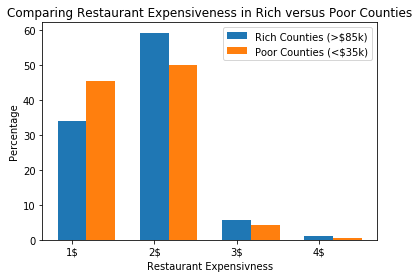

In [37]:
labels=["1$","2$","3$","4$"]

x_axis=np.arange(0, len(labels), 1)
width=0.35

plt.bar(x_axis,Rich_df['County'],width, label="Rich Counties (>$85k)",tick_label=labels)
plt.bar(x_axis+width,df['County'],width,label="Poor Counties (<$35k)")
plt.legend(loc='best')
plt.xlabel("Restaurant Expensivness")
plt.ylabel("Percentage")
plt.title("Comparing Restaurant Expensiveness in Rich versus Poor Counties")
plt.show()



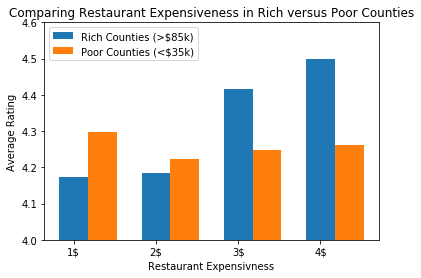

In [38]:
#what is average rating of restaurants by restaurant category
temp_df=Poor_County_Yelp_df.loc[Poor_County_Yelp_df["Price Cat"]!='']
temp_df=Poor_County_Yelp_df.groupby("Price Cat").mean()["Rating"]
temp_df=pd.DataFrame(temp_df)
# print(temp_df)

temp_df2=Rich_County_Yelp_df.loc[Rich_County_Yelp_df["Price Cat"]!='']
temp_df2=Rich_County_Yelp_df.groupby("Price Cat").mean()["Rating"]
temp_df2=pd.DataFrame(temp_df2)
temp_df2.head()

#plot into barchart
labels=["1$","2$","3$","4$"]

x_axis=np.arange(0, len(labels), 1)
width=0.35

plt.bar(x_axis,temp_df['Rating'],width, label="Rich Counties (>$85k)",tick_label=labels)
plt.bar(x_axis+width,temp_df2['Rating'],width,label="Poor Counties (<$35k)")
plt.legend(loc='best')
plt.xlabel("Restaurant Expensivness")
plt.ylabel("Average Rating")
plt.ylim(4,4.6)
plt.title("Comparing Restaurant Expensiveness in Rich versus Poor Counties")
plt.show()



In [39]:
#charting popular restaurant types in rich counties


r_data=Rich_County_Yelp_df.groupby(["Type","Price Cat"])
r_data=r_data["County"].count()
r_data=r_data.sort_values(ascending=False)
r_data=r_data/r_data.sum()
r_data=pd.DataFrame(r_data)
r_data=r_data.iloc[0:15]
total=r_data["County"].sum()
r_data=r_data["County"]/total
r_data=pd.DataFrame(r_data)
r_data=r_data.reset_index()
print(r_data)
rich_star_count=r_data[r_data["Price Cat"]=="$"]
rich_star_count




                      Type Price Cat    County
0           American (New)        $$  0.108225
1                    Pizza        $$  0.102453
2                  Mexican         $  0.086580
3                  Italian        $$  0.083694
4                  Mexican        $$  0.066378
5                  Seafood        $$  0.064935
6                   Indian        $$  0.063492
7   American (Traditional)        $$  0.062049
8                    Pizza         $  0.059163
9                     Thai        $$  0.056277
10          American (New)       $$$  0.053391
11      Breakfast & Brunch        $$  0.050505
12                Barbeque        $$  0.050505
13      Breakfast & Brunch         $  0.047619
14                   Delis         $  0.044733


,Type,Price Cat,County
2,Mexican,$,0.086580
8,Pizza,$,0.059163
13,Breakfast & Brunch,$,0.047619
14,Delis,$,0.044733


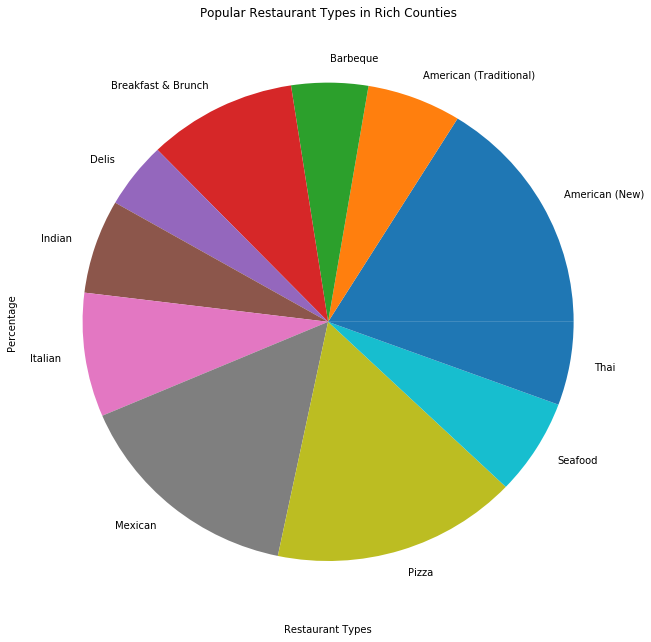

In [40]:
#create pie chart for popular restaurant types in rich counties
ab_chart=r_data.groupby("Type").sum()
ab_chart


chart_rich=ab_chart["County"].plot(kind='pie',figsize=(11,11))
chart_rich.set_xlabel("Restaurant Types")
chart_rich.set_ylabel("Percentage")
chart_rich.set_title("Popular Restaurant Types in Rich Counties")
plt.show()

In [ ]:
#charting popular restaurant types in poor counties
data=Poor_County_Yelp_df.groupby(["Type","Price Cat"])
data=data["County"].count()
data=data.sort_values(ascending=False)
data=data/data.sum()
data=pd.DataFrame(data)
data=data.iloc[0:15]
total=data["County"].sum()
data=data["County"]/total
data=data.reset_index()
print(data)
count_one_star=data[data["Price Cat"]=="$"]
count_one_star




                      Type Price Cat    County
0                  Mexican         $  0.189189
1   American (Traditional)        $$  0.086486
2           American (New)        $$  0.075676
3   American (Traditional)         $  0.064865
4                  Mexican        $$  0.064865
5                  Burgers         $  0.064865
6                    Pizza        $$  0.059459
7                  Seafood        $$  0.059459
8       Breakfast & Brunch         $  0.059459
9                 Barbeque         $  0.048649
10                   Delis         $  0.048649
11                   Pizza         $  0.048649
12                    Thai        $$  0.043243
13               Fast Food         $  0.043243
14              Sandwiches         $  0.043243


,Type,Price Cat,County
0,Mexican,$,0.189189
3,American (Traditional),$,0.064865
5,Burgers,$,0.064865
8,Breakfast & Brunch,$,0.059459
9,Barbeque,$,0.048649
10,Delis,$,0.048649
11,Pizza,$,0.048649
13,Fast Food,$,0.043243
14,Sandwiches,$,0.043243


In [ ]:
#create pie chart for popular restaurant types in poor counties
ab_chart=data.groupby("Type").sum()
ab_chart


chart_rich=ab_chart["County"].plot(kind='pie',figsize=(14,14))
chart_rich.set_xlabel("Restaurant Types")
chart_rich.set_ylabel("Percentage")
chart_rich.set_title("Popular Restaurant Types in Poor Counties")
plt.show()

In [ ]:
#charting popular restaurant types in non-diverse counties

ndiv=NonDiverse_County_Yelp_df.groupby("Type")
ndiv=ndiv["County"].count()
ndiv=ndiv.sort_values(ascending=False)
ndiv=ndiv/ndiv.sum()
ndiv=pd.DataFrame(ndiv)
ndiv=ndiv.iloc[0:15]
total=ndiv["County"].sum()
ndiv=ndiv["County"]/total
ndiv=pd.DataFrame(ndiv)



# #create pie chart
chart_non_diverse=ndiv["County"].plot(kind='pie',figsize=(11,11))
chart_non_diverse.set_xlabel("Restaurant Types")
chart_non_diverse.set_ylabel("Percentage")
chart_non_diverse.set_title("Top 15 Common Restauraunt Types where White Population is greater than 80%")
plt.show()


In [ ]:
#charting popular restaurant types in counties where asian population is greater than 20%

div_df=Asian_County_Yelp_df.groupby("Type")
div=div_df["County"].count()
div=div.sort_values(ascending=False)
div=div/div.sum()
div=pd.DataFrame(div)
div=div.iloc[0:15]
# div=div.loc[div["County"]>=0.02]
total=div["County"].sum()
div=div["County"]/total
div=pd.DataFrame(div)



chart_diverse=div["County"].plot(kind='pie',figsize=(12,12))

chart_diverse.set_xlabel("Restaurant Types")
chart_diverse.set_ylabel("Percentage")
chart_diverse.set_title("Top 15 Common Restauraunt Types where Asian Population is greater 20%")
plt.show()


In [ ]:
#charting popular restaurant types in counties where latino's are greater than 50% of population
div_df=Latino_County_Yelp_df.groupby("Type")
div=div_df["County"].count()
div=div.sort_values(ascending=False)
div=div/div.sum()
div=pd.DataFrame(div)
div=div.iloc[0:15]
# div=div.loc[div["County"]>=0.02]
total=div["County"].sum()
div=div["County"]/total
div=pd.DataFrame(div)



chart_diverse=div["County"].plot(kind='pie',figsize=(12,12))

chart_diverse.set_xlabel("Restaurant Types")
chart_diverse.set_ylabel("Percentage")
chart_diverse.set_title("Top 15 Common Restauraunt Types where Latino Population is greater 50%")
plt.show()


#Where are the Opportunities? ANALYZING COUNTIES [FRESNO] 

In [ ]:
#Filter for Fresno
Fresno_County_Yelp_df=Latino_County_Yelp_df.loc[Latino_County_Yelp_df["County"]=="Fresno"]

#filter for top 15 most common restaurants (top 50 rated resturants in Fresno)
Fresno_df=Fresno_County_Yelp_df.groupby("Type")
df=Fresno_df["County"].count()
df=df.sort_values(ascending=False)
df=df/df.sum()
df=pd.DataFrame(df)
df=df.iloc[0:15]
# div=div.loc[div["County"]>=0.02]
total=df["County"].sum()
df=df["County"]/total
df=pd.DataFrame(df)
df


#Create Pie Chart

chart_Fresno=df["County"].plot(kind='pie',figsize=(12,12))

chart_Fresno.set_xlabel("Restaurant Types")
chart_Fresno.set_ylabel("Percentage")
chart_Fresno.set_title("Top 15 Common Restauraunt Types in Fresno")
plt.show()



In [ ]:
#What types of restaurants have low ratings but a lot of reviews. There may be opportunity to open similar type of establishment


#count of restaurants
count=Fresno_County_Yelp_df.groupby("Type")
count=count["County"].count()
count=count.sort_values(ascending=False)
count=pd.DataFrame(count)
count=count.reset_index()

#average rating by resteraunt type
div_df=Fresno_County_Yelp_df.groupby("Type")
div=div_df["Rating"].mean()
div=div.sort_values(ascending=False)
div=pd.DataFrame(div)
div=div.reset_index()

#get sum of review counts
sum_df=Fresno_County_Yelp_df.groupby("Type")
sums=sum_df["Review Count"].mean()
sums=sums.sort_values(ascending=False)
sums=pd.DataFrame(sums)
sums=sums.reset_index()


#merge

Fresno_merge=pd.merge(div,sums,on="Type")
Fresno_merge=pd.merge(Fresno_merge,count,on="Type",how="outer")
Fresno_merge=Fresno_merge.sort_values("Rating",ascending=True)
Fresno_merge=Fresno_merge.rename(columns={"County":"Number of Restaurants"})
Fresno_merge=Fresno_merge.reset_index(drop=True)
Fresno_merge.head(10)


#you want to open up the type of restaurant that has low ratings, high review count, and low number of restaurants
